# Tequila Chemistry Basics

Here we show the basics of the tequila chemistry module.  
In order for this to work you need to have psi4 installed in the same python environment as tequila.  
If you are in a conda environment installing psi4 is easy:
`conda install psi4 -c psi4`  
But better check the [psi4 website](http://www.psicode.org/) for up to date instructions.

In some cases problems with the environment were observed which are suspected to originate from conflicts between psi4 and tequila dependcies. Usually the safest way is to install psi4 **first** and then install tequila

Basic functionality is currently also provided with PySCF which might be easier to install. 

At the moment we only support closed-shell molecules

This tutorial will give an overview over:

- Initialization of molecules within tequila
- Usage of different qubit encodings from openermion (JW, BK, BKSF, Tapered-BK)
- Using basic functionality of Psi4 with tequila
- Setting up active spaces
- Constructing UCC based quantum circuits with tequila

**There might be issues with psi4 and jupyter, currently the workarround is to reload the kernel before a cell gets executed, or run as a regular python script**

In [21]:
import tequila as tq

## Initialize Molecules

Molecules can be initialized by passing their geometries as string or the name of a `xyz` file.

In [22]:
import tequila as tq
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g")
print(molecule)

# lets also print some information about the orbitals
# we need it later

print("The Orbitals are:")
for orbital in molecule.orbitals:
    print(orbital)

<class 'tequila.quantumchemistry.psi4_interface.QuantumChemistryPsi4'>
Qubit Encoding
transformation=<function jordan_wigner at 0x7f8ccbd00730>
basis_set       : sto-3g          
geometry        : H 0.0 0.0 0.0
Li 0.0 0.0 1.6 
description     :                 
multiplicity    : 1               
charge          : 0               
closed_shell    : True            
name            : molecule        

Psi4 Data
Point Group (full) : c_inf_v         
Point Group (used) : c2v             
nirrep          : 4 
irreps          : ['A1', 'A2', 'B1', 'B2'] 
mos per irrep   : [4, 0, 1, 1]    

The Orbitals are:
0 : 0A1 energy = -2.348839 
1 : 1A1 energy = -0.285276 
2 : 2A1 energy = +0.078216 
3 : 0B1 energy = +0.163950 
4 : 0B2 energy = +0.163950 
5 : 3A1 energy = +0.547769 


You can initialize a tequila `QubitHamiltonian` from a molecule with `make_hamiltonian`.
The standard transformation is the `jordan-wigner` transformation.  
You can use other transformations by initializing the molecule with the `transformation` keyword.

In [23]:
import tequila as tq
H = molecule.make_hamiltonian()
# the LiH Hamiltonian is already quite large, better not print the full thing
print("Hamiltonian has {} terms".format(len(H)))

Hamiltonian has 631 terms


In [24]:
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", transformation="bravyi-kitaev")
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))

Hamiltonian has 631 terms


## Using different Qubit Encodings of OpenFermion

The different qubit encodings of openfermion can be applied by passing the keyword `transformation` to the molecule and setting it to the name of the corresponding openfermion function.  

Some of those transformation might require additional keywords. Following `psi4` conventions those should be given to the `Molecule` initialization with the prefix `transformation__`. For most of them, `tequila` is however able to assign the keys automatically.

In the following we provide some examples using various transformations from openfermion

In [3]:
import tequila as tq
import numpy
geomstring = "H 0.0 0.0 0.0\nH 0.0 0.0 0.7"
basis_set = "sto-3g"

# Jordan-Wigner (this is the default)
mol = tq.chemistry.Molecule(geometry=geomstring, basis_set=basis_set, transformation="jordan_wigner")
H = mol.make_hamiltonian()
print("Jordan-Wigner\n", H)
eigenValues = numpy.linalg.eigvalsh(H.to_matrix())
print("lowest energy = ", eigenValues[0])

# Bravyi-Kitaev
mol = tq.chemistry.Molecule(geometry=geomstring, basis_set=basis_set, transformation="bravyi_kitaev")
H = mol.make_hamiltonian()
print("Bravyi-Kitaev\n", H)
eigenValues = numpy.linalg.eigvalsh(H.to_matrix())
print("lowest energy = ", eigenValues[0])

# symmetry_conserving_bravyi_kitaev
# this transformation will taper off two qubits of the Hamiltonian
# it needs additional information on the number of spin-orbitals and the active_fermions/electrons in the system
mol = tq.chemistry.Molecule(geometry=geomstring, basis_set=basis_set,
                              transformation="symmetry_conserving_bravyi_kitaev")
H = mol.make_hamiltonian()
print("Symmetry conserving Bravyi-Kitaev\n", H)
eigenValues = numpy.linalg.eigvalsh(H.to_matrix())
print("lowest energy = ", eigenValues[0])

# Symmetry 

Jordan-Wigner
 -0.0421+0.1777Z(0)+0.1777Z(1)-0.2427Z(2)-0.2427Z(3)+0.1706Z(0)Z(1)+0.0448Y(0)X(1)X(2)Y(3)-0.0448Y(0)Y(1)X(2)X(3)-0.0448X(0)X(1)Y(2)Y(3)+0.0448X(0)Y(1)Y(2)X(3)+0.1229Z(0)Z(2)+0.1677Z(0)Z(3)+0.1677Z(1)Z(2)+0.1229Z(1)Z(3)+0.1763Z(2)Z(3)
lowest energy =  -1.1361894540879054
Bravyi-Kitaev
 -0.0421+0.1777Z(0)+0.1777Z(0)Z(1)-0.2427Z(2)-0.2427Z(1)Z(2)Z(3)+0.1706Z(1)+0.0448Y(0)Z(1)Y(2)Z(3)+0.0448X(0)Z(1)X(2)+0.0448X(0)Z(1)X(2)Z(3)+0.0448Y(0)Z(1)Y(2)+0.1229Z(0)Z(2)+0.1677Z(0)Z(1)Z(2)Z(3)+0.1677Z(0)Z(1)Z(2)+0.1229Z(0)Z(2)Z(3)+0.1763Z(1)Z(3)
lowest energy =  -1.136189454087905
Symmetry conserving Bravyi-Kitaev
 -0.2879+0.4205Z(0)+0.4205Z(1)+0.0115Z(0)Z(1)+0.1790X(0)X(1)
lowest energy =  -1.1361894540879054


## Setting active spaces

You can define active spaces on your molcule by passing down a dictionary of active orbitals.  
The orbitals are grouped into the irreducible representation of the underlying symmetry group (see the printout of `print(molecule)` above).

Lets take the LiH molecule from above but initialize it with an active space containing the second two A1 orbitals (meaning the first 0A1 orbital is frozen) and the B1 orbital

In [26]:
import tequila as tq
active_orbitals = {"A1":[1,2], "B1":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Hamiltonian has 62 terms


Lets make the active space even smaller, so that we can print out stuff in this tutorial

In [27]:
import tequila as tq
active_orbitals = {"A1":[1], "B1":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))
print(H)

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Hamiltonian has 15 terms
-7.4711+0.1352Z(0)+0.1352Z(1)-0.0310Z(2)-0.0310Z(3)+0.1218Z(0)Z(1)+0.0059Y(0)X(1)X(2)Y(3)-0.0059Y(0)Y(1)X(2)X(3)-0.0059X(0)X(1)Y(2)Y(3)+0.0059X(0)Y(1)Y(2)X(3)+0.0617Z(0)Z(2)+0.0675Z(0)Z(3)+0.0675Z(1)Z(2)+0.0617Z(1)Z(3)+0.0782Z(2)Z(3)


## Computing classical methods with Psi4

We can use psi4 to compute the energies (and sometimes other quantities) with the `compute_energy` function.
Here are some examples. Note that the energies are computed within the active space if one is set.

Note also that not all active spaces can be represented by psi4 which will mean you can/should not use the classical psi4 methods with those (a warning will be printed). You will still get the right active space hamiltonian however.

Active spaces which will not work for psi4 methds are the ones where the orbitals of individual irreps are not in one block ( e.g. {`"A1":[1,3]`} )

In [28]:
# YOU MIGHT HAVE TO RESTART THE JUPYTER KERNEL
import tequila as tq
active_orbitals = {"A1":[1], "B1":[0], "B2":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

mp2 = molecule.compute_energy(method="mp2")

# Note there are known issues for some methods when the active space as frozen virtuals as is the case here
# detci based methods are fine again 
fci = molecule.compute_energy(method="fci")

# for most coupled-cluster like models you can compute amplitudes
# Amplitudes are computed in c1 and in the full space, this is why the active space troubles from above usually don't hold
# Note that amplitudes are in closed-shell
amplitudes = molecule.compute_amplitudes("mp2")

# you can export a parameter dictionary which holds the indices of the amplitude as keys and values as values
# for this small active space that is only one amplitude for mp2
variables = amplitudes.make_parameter_dictionary()
print(variables)

# similar for ccsd since the singles are 0 due to symmetry (that changes if you change the active space)
amplitudes = molecule.compute_amplitudes("ccsd")
variables = amplitudes.make_parameter_dictionary()
print(variables)

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for mp2.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
{(1, 0, 1, 0): -0.026069395810974533, (2, 0, 2, 0): -0.026069395810972833}
{(1, 0, 1, 0): -0.027418022914682542, (2, 0, 2, 0): -0.027418022914682535}


## Hello World "H2" optimization with LiH in an active space

Lets do a small hand-constructed VQE like it would be done for the Hydrogen molecule in STO-3G, just that we use our active space LiH molecule from the cell above.
For consistency reasons we initialize everything again.  

Check the `BasicUsage` and `SciPyOptimizers` tutorial notebooks for more information about then

In [29]:
import tequila as tq
# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# define a hand designed circuit
U = tq.gates.Ry(angle="a", target=0) + tq.gates.X(target=[2,3])
U += tq.gates.X(target=1, control=0)
U += tq.gates.X(target=2, control=0)
U += tq.gates.X(target=3, control=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))


There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 2 expectationvalues

active variables : 1

E=-7.19702401  angles= {a: 0.0}  samples= None
E=-7.19766373  angles= {a: -0.0234220027923584}  samples= None
E=-7.20203763  angles= {a: -0.11711001396179199}  samples= None
E=-7.24749228  angles= {a: -0.49186205863952637}  samples= None
E=-7.68640044  angles= {a: -1.9908702373504639}  samples= None
E=-7.59671569  angles= {a: -7.986902952194214}  samples= None
E=-7.86212174  angles= {a: -3.129600457337474}  samples= None
E=-7.59889693  angles= {a: -1.7104055550334691}  samples= None
E=-7.86268191  angles= {a: -3.0777237637496633}  samples= None
E=-7.86268890  angles= {a: -3.0712456201159126} 

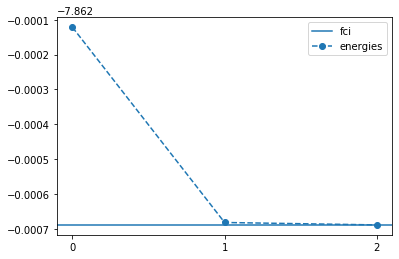

In [30]:
# some more information from the optimization
result.history.plot("energies", baselines={"fci":fci})

## Unitary Coupled-Cluster Style Construction

Here we show how to initialize in the style of unitary coupled-cluster.  
In this example we are gonna compute the `mp2` amplitudes and build a UCC type circuit from them.  
Here we use the cc2 amplitudes only to define an order on the trotterized gates and remove small amplitudes as classical prescreening.

We use again an active space to make the computation fast.

First we start with the manual construction and then show how to use in build convenience functions of tequila to.

An important function is the `make_excitation_generator` function of the molecule.  
This initializes a `QubitHamiltonian` which can be used to define a unitary gate which acts as excitation operation of electrons.

$$\displaystyle
U(\theta) = e^{-i\frac{\theta}{2} G_{iajbkc\dots}}
$$

In fermionic language the generator is defined as

$$
G_{ia,jb,jc,\dots} =  i ( a^\dagger_a a_i a^\dagger_b a_j a^\dagger_c a_k \dots - h.c. )
$$

The `make_excitation_generator` function gives back this generator in the qubit representation (depends on the chosen `transformation` of the molecule) and takes the indices as list of tuples  
  
$$
\text{make_excitation_generator(indices=[(a,i),(b,j),...])} = G_{ia,jb,jc,\dots}
$$

### Manual Construction

In [31]:
# YOU MIGHT HAVE TO RESTART THE JUPYTER KERNEL
import tequila as tq
threshold = 1.e-6

# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# compute classical amplitudes
amplitudes = molecule.compute_amplitudes(method="mp2")

# in this example there is only one closed-shell MP2 amplitude, therefore manual construction is reasonable in this tutorial
# first we make a dictionary out of the non-zero MP2 amplitudes
ampdict = amplitudes.make_parameter_dictionary(threshold=threshold)
print(ampdict)
# lets get the indices of the only amplitude which is there manually
indices = list(ampdict.keys())[0]

# the (1, 0, 1, 0) index in closed shell leads to the (2, 0, 3, 1) and (3, 1, 2, 0) excitations on the qubits
# but first we need to initialize the hartree fock state
U = molecule.prepare_reference()

# now add the two 2-electron excitations 
# for this we define the generators and build trotterized gates with them
# note that the two generators are actually the same
# we sum them up since we want to parametrize them with the same variable which we will call "a"
generator = molecule.make_excitation_generator(indices=[(3, 1),(2, 0)]) + molecule.make_excitation_generator(indices=[(3, 1),(2, 0)])
U += tq.gates.Trotterized(generators=[generator], angles=["a"], steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")
print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))



There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
{(1, 0, 1, 0): -0.026069395810974533}
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 16 expectationvalues

active variables : 1

E=-7.86186477  angles= {a: 0.0}  samples= None
E=-7.86259809  angles= {a: -0.0468440055847168}  samples= None
E=-7.86268890  angles= {a: -0.03516504106977361}  samples= None
Optimization terminated successfully.
         Current function value: -7.862689
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
VQE : -7.8626889f
FCI : -7.8626889f


### Automatic Construction

In [32]:
# YOU MIGHT HAVE TO RESTART THE JUPYTER KERNEL
import tequila as tq
threshold = 1.e-6

# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# make the UCCSD ansatz (note that this will be without singles since it starts from mp2)
U = molecule.make_uccsd_ansatz(initial_amplitudes="mp2", threshold=threshold, trotter_steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))
    
    

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 32 expectationvalues

active variables : 1

E=-7.86186477  angles= {(1, 0, 1, 0): 0.0}  samples= None
E=-7.86259809  angles= {(1, 0, 1, 0): -0.0468440055847168}  samples= None
E=-7.86268890  angles= {(1, 0, 1, 0): -0.03516504106977361}  samples= None
Optimization terminated successfully.
         Current function value: -7.862689
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
VQE : -7.8626889f
FCI : -7.8626889f


### Pi System of Benzene
Lets repeat the last cell with the pi system of the benzene molecule

In [33]:
# YOU MIGHT HAVE TO RESTART THE JUPYTER KERNEL
import tequila as tq
threshold = 1.e-6
active = {"B1u": [0], "B3g": [0, 1], "B2g": [0], "Au": [0], "b1u": [1]}
molecule = tq.quantumchemistry.Molecule(geometry="data/benzene.xyz", basis_set='sto-3g', active_orbitals=active)
H = molecule.make_hamiltonian()

# make the UCCSD ansatz
U = molecule.make_uccsd_ansatz(initial_amplitudes="cc2", threshold=threshold, trotter_steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# compute reference energies
fci = molecule.compute_energy("fci")
cisd = molecule.compute_energy("detci", options={"detci__ex_level": 2})

# optimize
# Scipy either `eps` (version <1.5) or 'finite_diff_rel_step' (verion > 1.5)
# for the 2-point stencil
result = tq.minimize(objective=E, method="BFGS", gradient="2-point", method_options={"eps":1.e-4, "finite_diff_rel_step":1.e-4, "gtol": 1.e-2}, initial_values={k:0.0 for k in E.extract_variables()})

print("VQE : {:+2.8}f".format(result.energy))
print("CISD: {:+2.8}f".format(cisd))
print("FCI : {:+2.8}f".format(fci))

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for detci.
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
grad instr      : 2-point
gradient        : scipy numerical 2-point
hessian         : scipy numerical None

active variables : 22

E=-227.88792153  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (4, 0): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0

E=-227.88792153  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (4, 0): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 1.4901161193847656e-08, (4, 2, 4, 2): 0.0, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0.0, (3, 0, 3, 0): 0.0, (5, 1, 5, 1): 0.0, (4, 0, 5, 1): 0.0}  samples= None
E=-227.88792153  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (4, 0): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.0, (4, 2, 4, 2): 1.4901161193847656e-08, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0.0, (3, 0, 3, 0): 0.0, (5, 1, 5, 1): 0.0, (4, 0, 5, 1): 0.0}  samples= None
E=-227.88792153  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0

E=-226.98589241  angles= {(3, 0, 5, 2): 0.15967559814453125, (3, 2, 5, 0): 0.03792572021484375, (5, 2, 5, 2): -0.11404037475585938, (4, 2, 3, 1): 0.35474395751953125, (4, 0): 0.0, (5, 0, 5, 0): -0.08678054809570312, (3, 1, 3, 1): -0.11080552637577057, (3, 1, 4, 2): 0.35474395751953125, (4, 1, 5, 0): -0.03792572021484375, (3, 2, 4, 1): -0.27155303955078125, (5, 1, 4, 0): -0.15964508056640625, (5, 0, 4, 1): -0.03792572021484375, (5, 0, 3, 2): 0.03792572021484375, (4, 0, 4, 0): -0.11172103881835938, (5, 2, 3, 0): 0.15967559814453125, (4, 1, 4, 1): -0.19395828247070312, (4, 2, 4, 2): -0.11080551147460938, (3, 2, 3, 2): -0.19396591186523438, (4, 1, 3, 2): -0.27155303955078125, (3, 0, 3, 0): -0.11172103881835938, (5, 1, 5, 1): -0.11404037475585938, (4, 0, 5, 1): -0.15964508056640625}  samples= None
E=-226.98589241  angles= {(3, 0, 5, 2): 0.15967559814453125, (3, 2, 5, 0): 0.03792572021484375, (5, 2, 5, 2): -0.11404037475585938, (4, 2, 3, 1): 0.35474395751953125, (4, 0): 0.0, (5, 0, 5, 0): -0

E=-226.98589241  angles= {(3, 0, 5, 2): 0.15967559814453125, (3, 2, 5, 0): 0.03792572021484375, (5, 2, 5, 2): -0.11404037475585938, (4, 2, 3, 1): 0.35474395751953125, (4, 0): 0.0, (5, 0, 5, 0): -0.08678054809570312, (3, 1, 3, 1): -0.11080551147460938, (3, 1, 4, 2): 0.35474395751953125, (4, 1, 5, 0): -0.03792572021484375, (3, 2, 4, 1): -0.27155303955078125, (5, 1, 4, 0): -0.15964508056640625, (5, 0, 4, 1): -0.03792572021484375, (5, 0, 3, 2): 0.03792572021484375, (4, 0, 4, 0): -0.11172103881835938, (5, 2, 3, 0): 0.15967559814453125, (4, 1, 4, 1): -0.19395828247070312, (4, 2, 4, 2): -0.11080551147460938, (3, 2, 3, 2): -0.19396592676639557, (4, 1, 3, 2): -0.27155303955078125, (3, 0, 3, 0): -0.11172103881835938, (5, 1, 5, 1): -0.11404037475585938, (4, 0, 5, 1): -0.15964508056640625}  samples= None
E=-226.98589241  angles= {(3, 0, 5, 2): 0.15967559814453125, (3, 2, 5, 0): 0.03792572021484375, (5, 2, 5, 2): -0.11404037475585938, (4, 2, 3, 1): 0.35474395751953125, (4, 0): 0.0, (5, 0, 5, 0): -0

E=-227.92306951  angles= {(3, 0, 5, 2): 0.013933302525321321, (3, 2, 5, 0): 0.003309400681034559, (5, 2, 5, 2): -0.009951170122664266, (4, 2, 3, 1): 0.030954979574746307, (4, 0): 0.0, (5, 0, 5, 0): -0.007572490871072196, (3, 1, 3, 1): -0.009668895753571799, (3, 1, 4, 2): 0.030954979574746307, (4, 1, 5, 0): -0.003309400681034559, (3, 2, 4, 1): -0.023695734950726827, (5, 1, 4, 0): -0.013930639559575166, (5, 0, 4, 1): -0.003309400681034559, (5, 0, 3, 2): 0.003309400681034559, (4, 0, 4, 0): -0.00974878472595646, (5, 2, 3, 0): 0.013933302525321321, (4, 1, 4, 1): -0.016924811670408584, (4, 2, 4, 2): -0.009668895753571799, (3, 2, 3, 2): -0.016925477411845125, (4, 1, 3, 2): -0.023695734950726827, (3, 0, 3, 0): -0.00974878472595646, (5, 1, 5, 1): -0.009951170122664266, (4, 0, 5, 1): -0.013930639559575166}  samples= None
E=-227.92306951  angles= {(3, 0, 5, 2): 0.013933302525321321, (3, 2, 5, 0): 0.003309400681034559, (5, 2, 5, 2): -0.009951170122664266, (4, 2, 3, 1): 0.030954979574746307, (4, 0)

E=-227.92306951  angles= {(3, 0, 5, 2): 0.013933302525321321, (3, 2, 5, 0): 0.003309400681034559, (5, 2, 5, 2): -0.009951170122664266, (4, 2, 3, 1): 0.030954979574746307, (4, 0): 0.0, (5, 0, 5, 0): -0.007572475969911002, (3, 1, 3, 1): -0.009668895753571799, (3, 1, 4, 2): 0.030954979574746307, (4, 1, 5, 0): -0.003309400681034559, (3, 2, 4, 1): -0.023695734950726827, (5, 1, 4, 0): -0.013930639559575166, (5, 0, 4, 1): -0.003309400681034559, (5, 0, 3, 2): 0.003309400681034559, (4, 0, 4, 0): -0.00974878472595646, (5, 2, 3, 0): 0.013933302525321321, (4, 1, 4, 1): -0.016924826571569778, (4, 2, 4, 2): -0.009668895753571799, (3, 2, 3, 2): -0.016925477411845125, (4, 1, 3, 2): -0.023695734950726827, (3, 0, 3, 0): -0.00974878472595646, (5, 1, 5, 1): -0.009951170122664266, (4, 0, 5, 1): -0.013930639559575166}  samples= None
E=-227.92306951  angles= {(3, 0, 5, 2): 0.013933302525321321, (3, 2, 5, 0): 0.003309400681034559, (5, 2, 5, 2): -0.009951170122664266, (4, 2, 3, 1): 0.030954979574746307, (4, 0)

E=-227.97392540  angles= {(3, 0, 5, 2): 0.04964998225259747, (3, 2, 5, 0): 0.03763132849440212, (5, 2, 5, 2): -0.04242021666881517, (4, 2, 3, 1): 0.04655115291794185, (4, 0): -7.653227904522876e-06, (5, 0, 5, 0): -0.03780328586451438, (3, 1, 3, 1): -0.03516195910732982, (3, 1, 4, 2): 0.046618756431098474, (4, 1, 5, 0): -0.03767661009283721, (3, 2, 4, 1): 0.0014890881062053496, (5, 1, 4, 0): -0.049691944584565724, (5, 0, 4, 1): -0.037667043557956546, (5, 0, 3, 2): 0.03760773104169649, (4, 0, 4, 0): -0.04236819697967633, (5, 2, 3, 0): 0.04964743117662931, (4, 1, 4, 1): -0.08348424988357302, (4, 2, 4, 2): -0.03516706125926615, (3, 2, 3, 2): -0.08338893602463916, (4, 1, 3, 2): 0.0016057998317493306, (3, 0, 3, 0): -0.042352252754875246, (5, 1, 5, 1): -0.04243423268547894, (4, 0, 5, 1): -0.04969258235355777}  samples= None
E=-227.97392540  angles= {(3, 0, 5, 2): 0.04964998225259747, (3, 2, 5, 0): 0.03763132849440212, (5, 2, 5, 2): -0.04242020176765397, (4, 2, 3, 1): 0.04655116781910305, (4, 

E=-227.97392540  angles= {(3, 0, 5, 2): 0.04964998225259747, (3, 2, 5, 0): 0.03763132849440212, (5, 2, 5, 2): -0.04242020176765397, (4, 2, 3, 1): 0.04655115291794185, (4, 0): -7.653227904522876e-06, (5, 0, 5, 0): -0.03780328586451438, (3, 1, 3, 1): -0.03516195910732982, (3, 1, 4, 2): 0.046618756431098474, (4, 1, 5, 0): -0.03767661009283721, (3, 2, 4, 1): 0.0014890881062053496, (5, 1, 4, 0): -0.049691944584565724, (5, 0, 4, 1): -0.037667043557956546, (5, 0, 3, 2): 0.037607745942857686, (4, 0, 4, 0): -0.04236819697967633, (5, 2, 3, 0): 0.04964743117662931, (4, 1, 4, 1): -0.08348424988357302, (4, 2, 4, 2): -0.03516706125926615, (3, 2, 3, 2): -0.08338893602463916, (4, 1, 3, 2): 0.0016057998317493306, (3, 0, 3, 0): -0.042352252754875246, (5, 1, 5, 1): -0.04243423268547894, (4, 0, 5, 1): -0.04969258235355777}  samples= None
E=-227.97392540  angles= {(3, 0, 5, 2): 0.04964998225259747, (3, 2, 5, 0): 0.03763132849440212, (5, 2, 5, 2): -0.04242020176765397, (4, 2, 3, 1): 0.04655115291794185, (4,

E=-227.96154760  angles= {(3, 0, 5, 2): 0.07620401883743472, (3, 2, 5, 0): 0.09503292078147403, (5, 2, 5, 2): -0.023234154770695674, (4, 2, 3, 1): 0.12759050262231347, (4, 0): -0.00029538899960931486, (5, 0, 5, 0): -0.04642953846882008, (3, 1, 3, 1): -0.02765668523846577, (3, 1, 4, 2): 0.12746855618799927, (4, 1, 5, 0): -0.09719792354358936, (3, 2, 4, 1): 0.058203154474313346, (5, 1, 4, 0): -0.06982391434293564, (5, 0, 4, 1): -0.09690859283939346, (5, 0, 3, 2): 0.0949489384668489, (4, 0, 4, 0): -0.038739592393027336, (5, 2, 3, 0): 0.07630975889781644, (4, 1, 4, 1): -0.21171997509615614, (4, 2, 4, 2): -0.027641639583270365, (3, 2, 3, 2): -0.2093630191381674, (4, 1, 3, 2): 0.05913539296319546, (3, 0, 3, 0): -0.03749938167144145, (5, 1, 5, 1): -0.024037613890736727, (4, 0, 5, 1): -0.06993398463442137}  samples= None
E=-227.96154760  angles= {(3, 0, 5, 2): 0.07620403373859591, (3, 2, 5, 0): 0.09503292078147403, (5, 2, 5, 2): -0.023234154770695674, (4, 2, 3, 1): 0.12759050262231347, (4, 0):

E=-227.96154760  angles= {(3, 0, 5, 2): 0.07620401883743472, (3, 2, 5, 0): 0.09503292078147403, (5, 2, 5, 2): -0.023234154770695674, (4, 2, 3, 1): 0.12759050262231347, (4, 0): -0.00029538899960931486, (5, 0, 5, 0): -0.04642953846882008, (3, 1, 3, 1): -0.02765668523846577, (3, 1, 4, 2): 0.12746855618799927, (4, 1, 5, 0): -0.09719792354358936, (3, 2, 4, 1): 0.05820316937547454, (5, 1, 4, 0): -0.06982391434293564, (5, 0, 4, 1): -0.09690859283939346, (5, 0, 3, 2): 0.0949489384668489, (4, 0, 4, 0): -0.038739592393027336, (5, 2, 3, 0): 0.07630975889781644, (4, 1, 4, 1): -0.21171997509615614, (4, 2, 4, 2): -0.027641639583270365, (3, 2, 3, 2): -0.2093630191381674, (4, 1, 3, 2): 0.05913539296319546, (3, 0, 3, 0): -0.03749938167144145, (5, 1, 5, 1): -0.024037613890736727, (4, 0, 5, 1): -0.06993398463442137}  samples= None
E=-227.96154760  angles= {(3, 0, 5, 2): 0.07620401883743472, (3, 2, 5, 0): 0.09503292078147403, (5, 2, 5, 2): -0.023234154770695674, (4, 2, 3, 1): 0.12759050262231347, (4, 0): 

E=-227.96154760  angles= {(3, 0, 5, 2): 0.07620401883743472, (3, 2, 5, 0): 0.09503292078147403, (5, 2, 5, 2): -0.023234154770695674, (4, 2, 3, 1): 0.12759050262231347, (4, 0): -0.00029538899960931486, (5, 0, 5, 0): -0.04642953846882008, (3, 1, 3, 1): -0.02765668523846577, (3, 1, 4, 2): 0.12746855618799927, (4, 1, 5, 0): -0.09719792354358936, (3, 2, 4, 1): 0.058203154474313346, (5, 1, 4, 0): -0.06982391434293564, (5, 0, 4, 1): -0.09690859283939346, (5, 0, 3, 2): 0.0949489384668489, (4, 0, 4, 0): -0.038739592393027336, (5, 2, 3, 0): 0.07630975889781644, (4, 1, 4, 1): -0.21171997509615614, (4, 2, 4, 2): -0.027641639583270365, (3, 2, 3, 2): -0.2093630191381674, (4, 1, 3, 2): 0.05913539296319546, (3, 0, 3, 0): -0.03749939657260264, (5, 1, 5, 1): -0.024037613890736727, (4, 0, 5, 1): -0.06993398463442137}  samples= None
E=-227.96154760  angles= {(3, 0, 5, 2): 0.07620401883743472, (3, 2, 5, 0): 0.09503292078147403, (5, 2, 5, 2): -0.023234154770695674, (4, 2, 3, 1): 0.12759050262231347, (4, 0):

E=-227.98474708  angles= {(3, 0, 5, 2): 0.06031745783929324, (3, 2, 5, 0): 0.0606911025669231, (5, 2, 5, 2): -0.03471264712558053, (4, 2, 3, 1): 0.07910685426192204, (4, 0): -0.00012324447936165977, (5, 0, 5, 0): -0.04126868513694164, (3, 1, 3, 1): -0.03214690225050113, (3, 1, 4, 2): 0.07909831042811526, (4, 1, 5, 0): -0.06158793355943687, (3, 2, 4, 1): 0.024272664398688772, (5, 1, 4, 0): -0.05777950201574506, (5, 0, 4, 1): -0.06146597818165213, (5, 0, 3, 2): 0.06064324687994585, (4, 0, 4, 0): -0.0409104882536157, (5, 2, 3, 0): 0.06035841024535039, (4, 1, 4, 1): -0.135000013359947, (4, 2, 4, 2): -0.032143895581543326, (3, 2, 3, 2): -0.13399613662393675, (4, 1, 3, 2): 0.02471699530975328, (3, 0, 3, 0): -0.0404027230235849, (5, 1, 5, 1): -0.03504381273016713, (4, 0, 5, 1): -0.057824101792485434}  samples= None
E=-227.98474708  angles= {(3, 0, 5, 2): 0.06031745783929324, (3, 2, 5, 0): 0.0606911025669231, (5, 2, 5, 2): -0.03471264712558053, (4, 2, 3, 1): 0.07910685426192204, (4, 0): -0.000

E=-227.98474708  angles= {(3, 0, 5, 2): 0.06031745783929324, (3, 2, 5, 0): 0.0606911025669231, (5, 2, 5, 2): -0.03471264712558053, (4, 2, 3, 1): 0.07910685426192204, (4, 0): -0.00012324447936165977, (5, 0, 5, 0): -0.04126868513694164, (3, 1, 3, 1): -0.03214688734933994, (3, 1, 4, 2): 0.07909831042811526, (4, 1, 5, 0): -0.06158793355943687, (3, 2, 4, 1): 0.024272664398688772, (5, 1, 4, 0): -0.05777950201574506, (5, 0, 4, 1): -0.06146597818165213, (5, 0, 3, 2): 0.06064324687994585, (4, 0, 4, 0): -0.0409104882536157, (5, 2, 3, 0): 0.06035841024535039, (4, 1, 4, 1): -0.135000013359947, (4, 2, 4, 2): -0.03214391048270452, (3, 2, 3, 2): -0.13399613662393675, (4, 1, 3, 2): 0.02471699530975328, (3, 0, 3, 0): -0.0404027230235849, (5, 1, 5, 1): -0.03504381273016713, (4, 0, 5, 1): -0.057824101792485434}  samples= None
E=-227.98474708  angles= {(3, 0, 5, 2): 0.06031745783929324, (3, 2, 5, 0): 0.0606911025669231, (5, 2, 5, 2): -0.03471264712558053, (4, 2, 3, 1): 0.07910685426192204, (4, 0): -0.0001

E=-227.99329612  angles= {(3, 0, 5, 2): 0.08707385973751049, (3, 2, 5, 0): 0.06788129072834981, (5, 2, 5, 2): -0.026526514581356637, (4, 2, 3, 1): 0.10975668974976666, (4, 0): -0.00022975502912755133, (5, 0, 5, 0): -0.045344918386054645, (3, 1, 3, 1): -0.027058859312254734, (3, 1, 4, 2): 0.10961847353994181, (4, 1, 5, 0): -0.06542315491282415, (3, 2, 4, 1): 0.057028871613933, (5, 1, 4, 0): -0.08595163959829191, (5, 0, 4, 1): -0.06517275039185101, (5, 0, 3, 2): 0.06782335846654827, (4, 0, 4, 0): -0.03916840169732353, (5, 2, 3, 0): 0.08714480824323655, (4, 1, 4, 1): -0.19149441064599296, (4, 2, 4, 2): -0.027028792662400058, (3, 2, 3, 2): -0.1896933462170493, (4, 1, 3, 2): 0.057924997969014624, (3, 0, 3, 0): -0.03797015924566293, (5, 1, 5, 1): -0.027355127989788654, (4, 0, 5, 1): -0.08604731068242014}  samples= None
E=-227.99329612  angles= {(3, 0, 5, 2): 0.08707385973751049, (3, 2, 5, 0): 0.06788129072834981, (5, 2, 5, 2): -0.026526514581356637, (4, 2, 3, 1): 0.10975667484860546, (4, 0):

E=-227.99329612  angles= {(3, 0, 5, 2): 0.08707385973751049, (3, 2, 5, 0): 0.06788129072834981, (5, 2, 5, 2): -0.026526514581356637, (4, 2, 3, 1): 0.10975667484860546, (4, 0): -0.00022975502912755133, (5, 0, 5, 0): -0.045344918386054645, (3, 1, 3, 1): -0.027058859312254734, (3, 1, 4, 2): 0.10961847353994181, (4, 1, 5, 0): -0.06542315491282415, (3, 2, 4, 1): 0.057028871613933, (5, 1, 4, 0): -0.08595163959829191, (5, 0, 4, 1): -0.06517275039185101, (5, 0, 3, 2): 0.06782335846654827, (4, 0, 4, 0): -0.039168416598484725, (5, 2, 3, 0): 0.08714480824323655, (4, 1, 4, 1): -0.19149441064599296, (4, 2, 4, 2): -0.027028792662400058, (3, 2, 3, 2): -0.1896933462170493, (4, 1, 3, 2): 0.057924997969014624, (3, 0, 3, 0): -0.03797015924566293, (5, 1, 5, 1): -0.027355127989788654, (4, 0, 5, 1): -0.08604731068242014}  samples= None
E=-227.99329612  angles= {(3, 0, 5, 2): 0.08707385973751049, (3, 2, 5, 0): 0.06788129072834981, (5, 2, 5, 2): -0.026526514581356637, (4, 2, 3, 1): 0.10975667484860546, (4, 0)

E=-227.98997066  angles= {(3, 0, 5, 2): 0.08280939160461387, (3, 2, 5, 0): 0.05357006629993384, (5, 2, 5, 2): -0.04732922188614155, (4, 2, 3, 1): 0.11422202374145507, (4, 0): -0.0012078693767894647, (5, 0, 5, 0): -0.08872146015396473, (3, 1, 3, 1): -0.03279166042095594, (3, 1, 4, 2): 0.11396224811748439, (4, 1, 5, 0): -0.0628103032425128, (3, 2, 4, 1): 0.0629558073812401, (5, 1, 4, 0): -0.06902270773802367, (5, 0, 4, 1): -0.062634564378297, (5, 0, 3, 2): 0.05352211058829641, (4, 0, 4, 0): -0.0449109608549406, (5, 2, 3, 0): 0.08288230023446068, (4, 1, 4, 1): -0.19402149156622733, (4, 2, 4, 2): -0.03260106358548944, (3, 2, 3, 2): -0.19198013526300886, (4, 1, 3, 2): 0.06432979184792514, (3, 0, 3, 0): -0.04591755395989061, (5, 1, 5, 1): -0.04601654852473335, (4, 0, 5, 1): -0.06916472927151207}  samples= None
E=-227.98997066  angles= {(3, 0, 5, 2): 0.08280937670345268, (3, 2, 5, 0): 0.053570081201095035, (5, 2, 5, 2): -0.04732922188614155, (4, 2, 3, 1): 0.11422202374145507, (4, 0): -0.00120

E=-227.98997066  angles= {(3, 0, 5, 2): 0.08280937670345268, (3, 2, 5, 0): 0.05357006629993384, (5, 2, 5, 2): -0.04732922188614155, (4, 2, 3, 1): 0.11422202374145507, (4, 0): -0.0012078693767894647, (5, 0, 5, 0): -0.08872146015396473, (3, 1, 3, 1): -0.03279166042095594, (3, 1, 4, 2): 0.11396224811748439, (4, 1, 5, 0): -0.0628103032425128, (3, 2, 4, 1): 0.0629558073812401, (5, 1, 4, 0): -0.06902270773802367, (5, 0, 4, 1): -0.06263457927945819, (5, 0, 3, 2): 0.05352211058829641, (4, 0, 4, 0): -0.0449109608549406, (5, 2, 3, 0): 0.08288230023446068, (4, 1, 4, 1): -0.19402149156622733, (4, 2, 4, 2): -0.03260106358548944, (3, 2, 3, 2): -0.19198013526300886, (4, 1, 3, 2): 0.06432979184792514, (3, 0, 3, 0): -0.04591755395989061, (5, 1, 5, 1): -0.04601654852473335, (4, 0, 5, 1): -0.06916472927151207}  samples= None
E=-227.98997066  angles= {(3, 0, 5, 2): 0.08280937670345268, (3, 2, 5, 0): 0.05357006629993384, (5, 2, 5, 2): -0.04732922188614155, (4, 2, 3, 1): 0.11422202374145507, (4, 0): -0.0012

E=-227.99408759  angles= {(3, 0, 5, 2): 0.08577412281337676, (3, 2, 5, 0): 0.06351948962124647, (5, 2, 5, 2): -0.03286680169002584, (4, 2, 3, 1): 0.11111763203587179, (4, 0): -0.0005278665056015189, (5, 0, 5, 0): -0.05856529997198761, (3, 1, 3, 1): -0.02880611289966171, (3, 1, 4, 2): 0.11094237708544925, (4, 1, 5, 0): -0.0646268052108635, (3, 2, 4, 1): 0.0588352939169918, (5, 1, 4, 0): -0.08079200884136108, (5, 0, 4, 1): -0.06439915742506253, (5, 0, 3, 2): 0.0634645980306166, (4, 0, 4, 0): -0.04091862936069286, (5, 2, 3, 0): 0.08584567327091376, (4, 1, 4, 1): -0.19226461898216662, (4, 2, 4, 2): -0.02872711956678089, (3, 2, 3, 2): -0.19039031795711742, (4, 1, 3, 2): 0.059877062739680284, (3, 0, 3, 0): -0.04039238071500666, (5, 1, 5, 1): -0.03304278980772663, (4, 0, 5, 1): -0.08090180670006021}  samples= None
E=-227.99408759  angles= {(3, 0, 5, 2): 0.08577413771453796, (3, 2, 5, 0): 0.06351948962124647, (5, 2, 5, 2): -0.03286680169002584, (4, 2, 3, 1): 0.11111763203587179, (4, 0): -0.000

E=-227.99408759  angles= {(3, 0, 5, 2): 0.08577412281337676, (3, 2, 5, 0): 0.06351948962124647, (5, 2, 5, 2): -0.03286680169002584, (4, 2, 3, 1): 0.11111763203587179, (4, 0): -0.0005278665056015189, (5, 0, 5, 0): -0.05856529997198761, (3, 1, 3, 1): -0.02880611289966171, (3, 1, 4, 2): 0.11094237708544925, (4, 1, 5, 0): -0.0646268052108635, (3, 2, 4, 1): 0.0588352939169918, (5, 1, 4, 0): -0.08079202374252227, (5, 0, 4, 1): -0.06439915742506253, (5, 0, 3, 2): 0.0634645980306166, (4, 0, 4, 0): -0.04091862936069286, (5, 2, 3, 0): 0.08584567327091376, (4, 1, 4, 1): -0.19226461898216662, (4, 2, 4, 2): -0.02872711956678089, (3, 2, 3, 2): -0.19039031795711742, (4, 1, 3, 2): 0.059877062739680284, (3, 0, 3, 0): -0.04039238071500666, (5, 1, 5, 1): -0.03304278980772663, (4, 0, 5, 1): -0.08090180670006021}  samples= None
E=-227.99408759  angles= {(3, 0, 5, 2): 0.08577412281337676, (3, 2, 5, 0): 0.06351948962124647, (5, 2, 5, 2): -0.03286680169002584, (4, 2, 3, 1): 0.11111763203587179, (4, 0): -0.000

E=-227.99408759  angles= {(3, 0, 5, 2): 0.08577412281337676, (3, 2, 5, 0): 0.06351948962124647, (5, 2, 5, 2): -0.03286680169002584, (4, 2, 3, 1): 0.11111763203587179, (4, 0): -0.0005278665056015189, (5, 0, 5, 0): -0.05856529997198761, (3, 1, 3, 1): -0.02880611289966171, (3, 1, 4, 2): 0.11094237708544925, (4, 1, 5, 0): -0.0646268052108635, (3, 2, 4, 1): 0.0588352939169918, (5, 1, 4, 0): -0.08079200884136108, (5, 0, 4, 1): -0.06439915742506253, (5, 0, 3, 2): 0.0634645980306166, (4, 0, 4, 0): -0.04091862936069286, (5, 2, 3, 0): 0.08584567327091376, (4, 1, 4, 1): -0.19226461898216662, (4, 2, 4, 2): -0.02872711956678089, (3, 2, 3, 2): -0.19039031795711742, (4, 1, 3, 2): 0.059877062739680284, (3, 0, 3, 0): -0.04039238071500666, (5, 1, 5, 1): -0.03304278980772663, (4, 0, 5, 1): -0.0809018216012214}  samples= None
E=-227.99307690  angles= {(3, 0, 5, 2): 0.07585181104507067, (3, 2, 5, 0): 0.0668121651822515, (5, 2, 5, 2): -0.04090004122869767, (4, 2, 3, 1): 0.11144685377747938, (4, 0): -0.00068

E=-227.99307690  angles= {(3, 0, 5, 2): 0.07585181104507067, (3, 2, 5, 0): 0.0668121651822515, (5, 2, 5, 2): -0.04090004122869767, (4, 2, 3, 1): 0.11144685377747938, (4, 0): -0.0006858724588696886, (5, 0, 5, 0): -0.07312464671922668, (3, 1, 3, 1): -0.032062270494867665, (3, 1, 4, 2): 0.11117911805680128, (4, 1, 5, 0): -0.05760426767205905, (3, 2, 4, 1): 0.05925140616587922, (5, 1, 4, 0): -0.0805289390962269, (5, 0, 4, 1): -0.05740716410005206, (5, 0, 3, 2): 0.06674445553025438, (4, 0, 4, 0): -0.04327301976024128, (5, 2, 3, 0): 0.07585058371431866, (4, 1, 4, 1): -0.18918547182606674, (4, 2, 4, 2): -0.03191030146910742, (3, 2, 3, 2): -0.18804080510115848, (4, 1, 3, 2): 0.06049617260279229, (3, 0, 3, 0): -0.042735954465855486, (5, 1, 5, 1): -0.041168598205995055, (4, 0, 5, 1): -0.08065183263033539}  samples= None
E=-227.99307690  angles= {(3, 0, 5, 2): 0.07585181104507067, (3, 2, 5, 0): 0.0668121651822515, (5, 2, 5, 2): -0.04090004122869767, (4, 2, 3, 1): 0.11144685377747938, (4, 0): -0.0

E=-227.99307690  angles= {(3, 0, 5, 2): 0.07585181104507067, (3, 2, 5, 0): 0.0668121651822515, (5, 2, 5, 2): -0.04090004122869767, (4, 2, 3, 1): 0.11144685377747938, (4, 0): -0.0006858724588696886, (5, 0, 5, 0): -0.07312464671922668, (3, 1, 3, 1): -0.032062270494867665, (3, 1, 4, 2): 0.11117911805680128, (4, 1, 5, 0): -0.057604252770897854, (3, 2, 4, 1): 0.05925140616587922, (5, 1, 4, 0): -0.0805289390962269, (5, 0, 4, 1): -0.05740716410005206, (5, 0, 3, 2): 0.06674445553025438, (4, 0, 4, 0): -0.04327301976024128, (5, 2, 3, 0): 0.07585058371431866, (4, 1, 4, 1): -0.18918547182606674, (4, 2, 4, 2): -0.03191030146910742, (3, 2, 3, 2): -0.18804080510115848, (4, 1, 3, 2): 0.06049618750395348, (3, 0, 3, 0): -0.042735954465855486, (5, 1, 5, 1): -0.041168598205995055, (4, 0, 5, 1): -0.08065183263033539}  samples= None
E=-227.99307690  angles= {(3, 0, 5, 2): 0.07585181104507067, (3, 2, 5, 0): 0.0668121651822515, (5, 2, 5, 2): -0.04090004122869767, (4, 2, 3, 1): 0.11144685377747938, (4, 0): -0.

E=-227.99433226  angles= {(3, 0, 5, 2): 0.0827383149403895, (3, 2, 5, 0): 0.06452690912435269, (5, 2, 5, 2): -0.03532463333315067, (4, 2, 3, 1): 0.11121835996888467, (4, 0): -0.0005762096466064762, (5, 0, 5, 0): -0.06301985938988149, (3, 1, 3, 1): -0.02980235944926001, (3, 1, 4, 2): 0.11101480981296995, (4, 1, 5, 0): -0.06247820108679119, (3, 2, 4, 1): 0.05896260667138981, (5, 1, 4, 0): -0.08071152062227749, (5, 0, 4, 1): -0.06225990309808778, (5, 0, 3, 2): 0.06446809574890858, (4, 0, 4, 0): -0.04163897327629782, (5, 2, 3, 0): 0.08278759847184862, (4, 1, 4, 1): -0.19132253014270556, (4, 2, 4, 2): -0.02970103863986432, (3, 2, 3, 2): -0.189671466363622, (4, 1, 3, 2): 0.060066484181030576, (3, 0, 3, 0): -0.04110941519345137, (5, 1, 5, 1): -0.03552894360795747, (4, 0, 5, 1): -0.08082532520394987}  samples= None
E=-227.99433226  angles= {(3, 0, 5, 2): 0.0827383149403895, (3, 2, 5, 0): 0.06452690912435269, (5, 2, 5, 2): -0.03532463333315067, (4, 2, 3, 1): 0.11121835996888467, (4, 0): -0.0005

E=-227.99433226  angles= {(3, 0, 5, 2): 0.0827383149403895, (3, 2, 5, 0): 0.06452690912435269, (5, 2, 5, 2): -0.03532463333315067, (4, 2, 3, 1): 0.11121835996888467, (4, 0): -0.0005762096466064762, (5, 0, 5, 0): -0.06301984448872029, (3, 1, 3, 1): -0.02980235944926001, (3, 1, 4, 2): 0.11101480981296995, (4, 1, 5, 0): -0.06247820108679119, (3, 2, 4, 1): 0.05896260667138981, (5, 1, 4, 0): -0.08071152062227749, (5, 0, 4, 1): -0.06225990309808778, (5, 0, 3, 2): 0.06446809574890858, (4, 0, 4, 0): -0.04163897327629782, (5, 2, 3, 0): 0.08278759847184862, (4, 1, 4, 1): -0.19132254504386675, (4, 2, 4, 2): -0.02970103863986432, (3, 2, 3, 2): -0.189671466363622, (4, 1, 3, 2): 0.060066484181030576, (3, 0, 3, 0): -0.04110941519345137, (5, 1, 5, 1): -0.03552894360795747, (4, 0, 5, 1): -0.08082532520394987}  samples= None
E=-227.99433226  angles= {(3, 0, 5, 2): 0.0827383149403895, (3, 2, 5, 0): 0.06452690912435269, (5, 2, 5, 2): -0.03532463333315067, (4, 2, 3, 1): 0.11121835996888467, (4, 0): -0.0005

E=-227.99452524  angles= {(3, 0, 5, 2): 0.08222130542534446, (3, 2, 5, 0): 0.0660028667584018, (5, 2, 5, 2): -0.03943550786731799, (4, 2, 3, 1): 0.10694437133511851, (4, 0): -0.0008331376681388223, (5, 0, 5, 0): -0.059987168834792076, (3, 1, 3, 1): -0.03424685182406437, (3, 1, 4, 2): 0.10654979177212019, (4, 1, 5, 0): -0.06409568484895367, (3, 2, 4, 1): 0.05533375837170466, (5, 1, 4, 0): -0.07954522163709096, (5, 0, 4, 1): -0.06399296838515733, (5, 0, 3, 2): 0.06591253728315462, (4, 0, 4, 0): -0.04132073999310853, (5, 2, 3, 0): 0.08230513019471103, (4, 1, 4, 1): -0.18062796156552563, (4, 2, 4, 2): -0.034134387657602, (3, 2, 3, 2): -0.1790024803064667, (4, 1, 3, 2): 0.05668476777774481, (3, 0, 3, 0): -0.041267854113076166, (5, 1, 5, 1): -0.03940455985433554, (4, 0, 5, 1): -0.07956337342334902}  samples= None
E=-227.99452524  angles= {(3, 0, 5, 2): 0.08222130542534446, (3, 2, 5, 0): 0.0660028667584018, (5, 2, 5, 2): -0.039435492966156796, (4, 2, 3, 1): 0.1069443862362797, (4, 0): -0.0008

E=-227.99452524  angles= {(3, 0, 5, 2): 0.08222130542534446, (3, 2, 5, 0): 0.0660028667584018, (5, 2, 5, 2): -0.039435492966156796, (4, 2, 3, 1): 0.10694437133511851, (4, 0): -0.0008331376681388223, (5, 0, 5, 0): -0.059987168834792076, (3, 1, 3, 1): -0.03424685182406437, (3, 1, 4, 2): 0.10654979177212019, (4, 1, 5, 0): -0.06409568484895367, (3, 2, 4, 1): 0.05533375837170466, (5, 1, 4, 0): -0.07954522163709096, (5, 0, 4, 1): -0.06399296838515733, (5, 0, 3, 2): 0.06591255218431581, (4, 0, 4, 0): -0.04132073999310853, (5, 2, 3, 0): 0.08230513019471103, (4, 1, 4, 1): -0.18062796156552563, (4, 2, 4, 2): -0.034134387657602, (3, 2, 3, 2): -0.1790024803064667, (4, 1, 3, 2): 0.05668476777774481, (3, 0, 3, 0): -0.041267854113076166, (5, 1, 5, 1): -0.03940455985433554, (4, 0, 5, 1): -0.07956337342334902}  samples= None
E=-227.99452524  angles= {(3, 0, 5, 2): 0.08222130542534446, (3, 2, 5, 0): 0.0660028667584018, (5, 2, 5, 2): -0.039435492966156796, (4, 2, 3, 1): 0.10694437133511851, (4, 0): -0.00

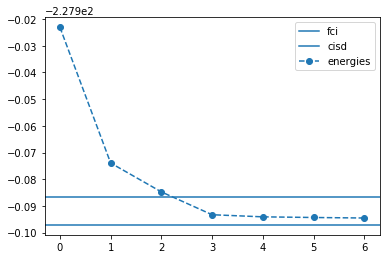

In [35]:
result.history.plot("energies", baselines={"fci":fci, "cisd": cisd}, filename="benzene_result_bfgs")

## Noisy optimization of an active space molecule with tapered qubit embeding

This example shows the combination of several features of tequila in a few lines

- automatic handling of active spaces
- consitent usage of qubit encodings (here the symmetry_conserving_bravyi_kitaev encoding from openfermion which reduces the number of qubits by 2)
- custom circuit construction
- unitary cluster circuits
- optimization of measurements (here the Hamiltonian will be grouped into two commuting groups, this can be seen by the optimizer output which holds two expectation values). See the [MeasurementGroups](https://github.com/aspuru-guzik-group/tequila/blob/master/tutorials/MeasurementGroups.ipynb) tutorial for more background information.
- interface to different quantum backends (you will need qiskit to run this cell)

In [5]:
import tequila as tq
# define the active space
active_orbitals = {"A1":[1], "B1":[0]}
samples = 1000000
backend = "qiskit"
device = "fake_rome"
# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6",
                                 basis_set="sto-3g",
                                 active_orbitals=active_orbitals,
                                 transformation="symmetry_conserving_bravyi_kitaev")

fci = molecule.compute_energy("fci")

H = molecule.make_hamiltonian()

# Toy circuit (no deeper meaning)
U = tq.gates.Ry(angle="a", target=0)
U += tq.gates.X(target=1, control=0)
E = tq.ExpectationValue(H=H, U=U, optimize_measurements=True)

vqe = tq.minimize(method="cobyla", objective=E, initial_values=0.0)
noisy_vqe = tq.minimize(method="cobyla", objective=E, samples=samples, backend=backend, device=device, initial_values=0.0)
 
# The same with UpGCCSD
UpGCCSD = molecule.make_upgccsd_ansatz(include_singles=False)
E2 = tq.ExpectationValue(H=H, U=UpGCCSD, optimize_measurements=True)
ucc = tq.minimize(method="cobyla", objective=E2, initial_values=0.0)
noisy_ucc = tq.minimize(method="cobyla", objective=E2, samples=samples,  backend=backend, device=device, initial_values=0.0)

print("VQE         = {:2.8f}".format(min(vqe.history.energies)))
print("VQE (noisy) = {:2.8f}".format(min(noisy_vqe.history.energies)))
print("UCC         = {:2.8f}".format(min(ucc.history.energies)))
print("UCC (noisy) = {:2.8f}".format(min(noisy_ucc.history.energies)))


trafo_args =  {'active_orbitals': 12, 'active_fermions': 4}
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
trafo_args =  {'active_orbitals': 4, 'active_fermions': 2}
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues

active variables : 1

E=-7.19702387  angles= {a: 0.0}  samples= None
E=-7.33012819  angles= {a: 1.0}  samples= None
E=-7.64648247  angles= {a: 2.0}  samples= None
E=-7.85523319  angles= {a: 3.0}  samples= None
E=-7.76445484  angles= {a: 4.0}  samples= None
E=-7.84895802  angles= {a: 3.5}  samples= None
E=-7.82776165  angles= {a: 2.75}  samples= None
E=-7.86143017  angles= {a: 3.125}  samples= None
E

In [6]:
# repeat printout
print("VQE         = {:2.3f}".format(min(vqe.history.energies)))
print("VQE (noisy) = {:2.3f}".format(min(noisy_vqe.history.energies)))
print("UCC         = {:2.3f}".format(min(ucc.history.energies)))
print("UCC (noisy) = {:2.3f}".format(min(noisy_ucc.history.energies)))

VQE         = -7.863
VQE (noisy) = -7.863
UCC         = -7.863
UCC (noisy) = -7.863
